In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# 参数，超参数
batch_size = 50
lr = 0.5

def to_onehot(y):
    for i in range(len(y)):
        if y.iloc[i,1600]==0:
            y.iloc[i,1600] = 'y'
        else:
            y.iloc[i,1600] = 'f'
    return pd.get_dummies(y)

# 准备数据
data_set = pd.read_csv('train.csv').iloc[:,1:]
# 仅把标签转化成onehot
data_set = to_onehot(data_set)

# 打乱数据，使数据随机
data_set = data_set.values.astype(np.float32)
np.random.shuffle(data_set)

# 划分训练集和验证集
sep = int(0.7*len(data_set))
train_data = data_set[:sep]
test_data = data_set[sep:]

# 创建模型
tf_input = tf.placeholder(tf.float32,[None,1602])
tf_x = tf_input[:,:1600]
x_img = tf.reshape(tf_x,[-1,40,40,1])
tf_y = tf_input[:,1600:]            # onehot

## CNN
conv1 = tf.layers.conv2d(           # shape:(40,40,1)
        inputs = x_img,
        filters = 10,               # 图像卷积后的深度
        kernel_size = 5,            # 扫描核5*5大小
        padding = 'same',
        activity_regularizer = tf.nn.relu
)                                   # shape:(40,40,10)
pool1 = tf.layers.max_pooling2d(
        inputs = conv1,
        pool_size = [2,2],
        strides = 2
)                                   # shape:(20,20,10)
conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 20,
        kernel_size = 5,
        padding = 'same',
        activity_regularizer = tf.nn.relu
)                                   # shape:(20,20,20)
pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = [2,2],
        strides = 2
)                                   # shape:(10,10,20)

shape = pool2.get_shape().as_list() # (ง •_•)ง
flat_data = tf.reshape(pool2,[-1,shape[1]*shape[2]*shape[3]])
output = tf.layers.dense(flat_data,2)
loss = tf.losses.softmax_cross_entropy(onehot_labels = tf_y,logits = output)
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

# 计算精度
accuracy = tf.metrics.accuracy(
        labels = tf.argmax(tf_y,axis = 1),
        predictions = tf.argmax(output,axis = 1)
)[1]

# 重要步骤！！初始化
sess = tf.Session()
#初始化全局和本地变量
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)

# 训练
for step in range(1200):
    batch_index = np.random.randint(len(train_data), size = batch_size)
    sess.run(train_op,{tf_input:train_data[batch_index]})
    if step % 50 ==0:
        acc_, loss_ = sess.run([accuracy, loss], {tf_input: test_data})
        print("Step: %i" % step, "| Accurate: %.8f" % acc_, "| Loss: %.2f" % loss_ )

    if step == 1199:
        predictions_2 = tf.argmax(output,axis = 1)
        test_data_ = test_data[:10]
        acc_,predictions_2_ ,output_,tf_y_= sess.run([accuracy,predictions_2,output,tf_y], feed_dict = {tf_input: test_data_})
        print('predictions_2:', predictions_2_,'tf_y_',tf_y_)
        print('accuracy:',acc_)
        print('output:',output_)
        


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Step: 0 | Accurate: 0.46750000 | Loss: 4211231.50
Step: 50 | Accurate: 0.62250000 | Loss: 47534.42
Step: 100 | Accurate: 0.69083333 | Loss: 11573.95
Step: 150 | Accurate: 0.75854164 | Loss: 2058.72
Step: 200 | Accurate: 0.79833335 | Loss: 1743.97
Step: 250 | Accurate: 0.81458336 | Loss: 5397.67
Step: 300 | Accurate: 0.83857143 | Loss: 734.37
Step: 350 | Accurate: 0.85531253 | Loss: 1069.76
Step: 400 | Accurate: 0.86907405 | Loss: 844.02
Step: 450 | Accurate: 0.87808335 | Loss: 1052.63
Step: 500 | Accurate: 0.88469696 | Loss: 2116.66
Step: 550 | Accurate: 0.88777781 | Loss: 2493.59
Step: 600 | Accurate: 0.89115387 | Loss: 2564.22
Step: 650 | Accurate: 0.89238095 | Loss: 4490.70
Step: 700 | Accurate: 0.89805555 | Loss: 986.43
Step: 750 | Accurate: 0.90380210 | Loss: 454.08
Step: 800 | Accurate: 0.90852

In [5]:
print(test_data_.shape)
print(len(test_data_))

(10, 1602)
10


In [9]:
print(test_data_[:,:1600].shape)
print(test_data_[5,:1600].shape)

(10, 1600)
(1600,)


In [25]:
print(predictions_2_)
print(len(predictions_2_))
for t in range(len(predictions_2_)):
    print(predictions_2_[t])
print(type(predictions_2_))

[1 0 1 1 1 0 1 0 1 1]
10
1
0
1
1
1
0
1
0
1
1
<class 'numpy.ndarray'>


In [28]:
pred = ['','','','','','','','','','']
for a in range(len(predictions_2_)):
    if predictions_2_[a]==1:
        pred[a] = '圆'
    else:
        pred[a] = '方'
    print(pred[a])

圆
方
圆
圆
圆
方
圆
方
圆
圆


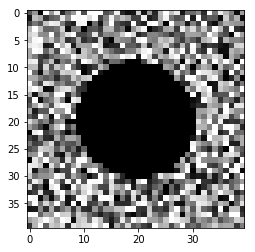

圆


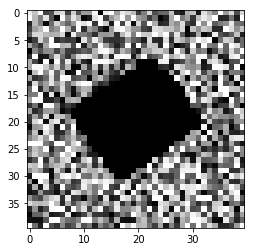

方


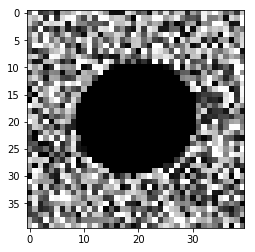

圆


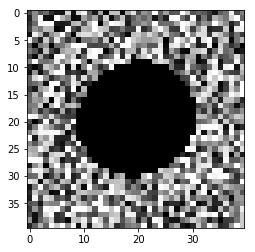

圆


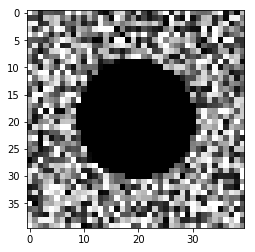

圆


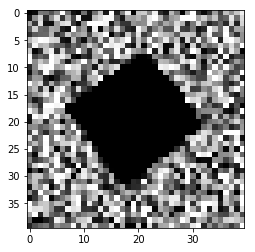

方


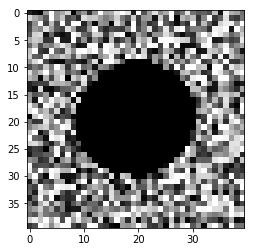

圆


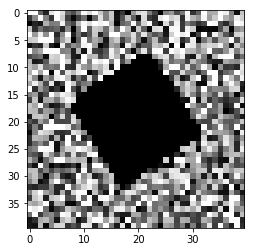

方


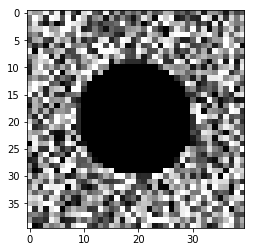

圆


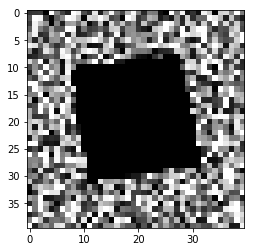

圆


In [32]:
import matplotlib.pyplot as plt

for i in range(len(test_data_)):
    plt.imshow(np.reshape(test_data_[i,:1600],(40,40)), cmap='gray')
#     plt.title('%i' % pred[i])
    plt.show()
    print(pred[i])